<a href="https://colab.research.google.com/github/ilkersigirci/ML-with-Colab/blob/master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pprint
import tensorflow as tf
tf.reset_default_graph()
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')
#os.chdir("/content")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#!mkdir mydata
!cp drive/My\ Drive/Colab\ Notebooks/Dataset/fake.csv mydata/

In [0]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [0]:
df = pd.read_csv('mydata/fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)

In [52]:
df.head()

,uuid,author,title,text,language,site_url,country,tokenized
0,4117842dadca66dc30787854e964bcae4605982b,BarbaraMcK42,,The article explains a lot of the background t...,english,ahtribune.com,DE,"[articl, explain, lot, background, white, helm..."
1,3ff601fe0c2543a3a23d1b5c99e45fdeee3597cd,Grant Stern,JUST IN: Republicans Sued Over Trump’s Call To...,\nThe Democratic National Committee just hau...,english,occupydemocrats.com,US,"[democrat, nation, committe, haul, donald, tru..."
2,7a01f9d909f81c6ee077e89a1afda807bffbdc0c,Bruce A. Dixon,Malcolm X on Hillary Clinton and Donald Trump,A Black Agenda Radio Commentary by Bruce A. ...,english,blackagendareport.com,EU,"[black, agenda, radio, commentari, bruce, dixo..."
3,de1b6202e6657cc30283d631c12e9a25d9b02d1c,Pepe Escobar,Why Hillary Won't Unleash WWIII : Information,Why Hillary Won't Unleash WWIII By Pepe Escob...,english,informationclearinghouse.info,US,"[hillari, wont, unleash, wwiii, pepe, escobar,..."
4,95cc17b10b54990fced13be769a46f8cf066aaaf,IWB,TRUMPED! LIBERAL NEWS OUTLET BLOOMBERG POLL CO...,TRUMPED! LIBERAL NEWS OUTLET BLOOMBERG POLL CO...,english,investmentwatchblog.com,US,"[trump, liber, news, outlet, bloomberg, poll, ..."


In [0]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [14]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 3.4305322488149006 min


In [15]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280

In [51]:
# choose k and visually inspect the bottom 10 words of the top k
k = 20000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

# k = 50,000 is too high, as the bottom words aren't even real words and are very rarely used (once in entire corpus)
# k = 15,000 is much more reasonable as these have been used at least 13 times in the corpus

[('trump', 26210),
 ('us', 26109),
 ('clinton', 25625),
 ('peopl', 20779),
 ('one', 20103),
 ('state', 19739),
 ('would', 18027),
 ('hillari', 16690),
 ('like', 15759),
 ('time', 15337)]

In [0]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [0]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [19]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 356.6925629198025 
minimum document length 0 
maximum document length 11892


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


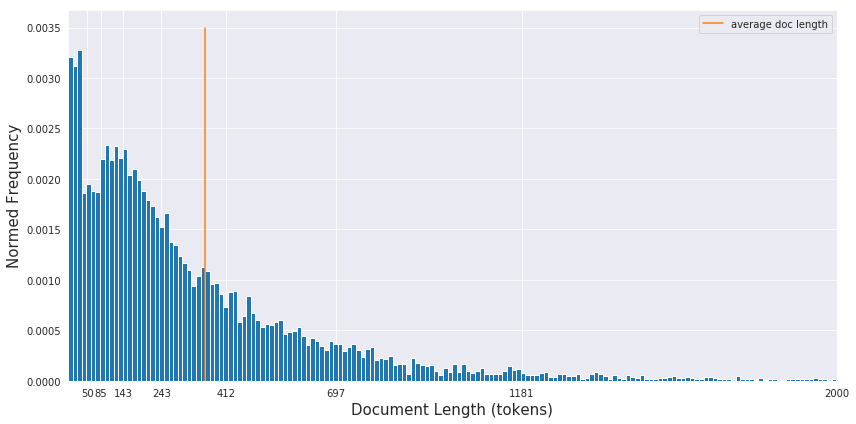

In [20]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [21]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10857 articles


In [0]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

In [0]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [57]:
print(len(df),len(train_df),len(test_df))

10857 10843 14


In [0]:
################################# LDA ##########################################

In [0]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [28]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Time to train LDA model on  10857 articles:  2.505556317170461 min


In [29]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(25,
  '0.082*"student" + 0.050*"project" + 0.046*"univers" + 0.023*"school" + 0.021*"colleg" + 0.021*"chicago" + 0.021*"action" + 0.021*"seri" + 0.020*"video" + 0.018*"organ" + 0.017*"donat" + 0.015*"issu" + 0.014*"robert" + 0.012*"wire" + 0.012*"part" + 0.012*"group" + 0.012*"commun" + 0.011*"effort" + 0.010*"releas" + 0.010*"campu"'),
 (64,
  '0.230*"rt" + 0.120*"jason" + 0.069*"insist" + 0.057*"unclear" + 0.054*"applaus" + 0.052*"paus" + 0.050*"ditz" + 0.035*"invas" + 0.035*"torch" + 0.026*"share" + 0.025*"last" + 0.021*"aros" + 0.019*"post" + 0.017*"mediev" + 0.013*"wink" + 0.011*"mum" + 0.010*"swarm" + 0.010*"undercut" + 0.004*"shore" + 0.003*"twoway"'),
 (71,
  '0.073*"protest" + 0.050*"soro" + 0.029*"revolut" + 0.024*"organ" + 0.024*"fuck" + 0.023*"georg" + 0.018*"group" + 0.018*"movement" + 0.017*"citi" + 0.014*"riot" + 0.013*"street" + 0.013*"violent" + 0.012*"activist" + 0.012*"peopl" + 0.012*"peac" + 0.010*"ralli" + 0.009*"violenc" + 0.008*"radic" + 0.007*"flag" + 0.007*"f

In [61]:
lda.show_topic(topicid=4, topn=20)

[('women', 0.18585542),
 ('men', 0.06715366),
 ('sexual', 0.061567966),
 ('woman', 0.046971254),
 ('girl', 0.04653853),
 ('rape', 0.040240236),
 ('sex', 0.036190752),
 ('male', 0.025901271),
 ('femal', 0.022699054),
 ('mexican', 0.020551067),
 ('man', 0.020107236),
 ('gender', 0.019506983),
 ('marriag', 0.018913228),
 ('feminist', 0.018642277),
 ('young', 0.016333696),
 ('assault', 0.014170785),
 ('rapist', 0.012528375),
 ('cultur', 0.0115168905),
 ('age', 0.010939005),
 ('hispan', 0.009762906)]

In [31]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

820


In [32]:
print(train_df.iloc[random_article_index,3])

No stopping him now! Dr. Duke will be in the debate tonight at 8 Eastern Time November 1, 2016 at 10:47 pm 
No stopping him now! Dr. Duke will be in the debate tonight at 8 Eastern Time 
Dr. Duke’s epic debate will be broadcast by C-SPAN at 8PM Eastern Time. (Not C-SPAN2 or C-SPAN3, but original C-SPAN. This is the big leagues, baby!) It will also be on C-SPAN radio. 
C-SPAN’s website has live TV streaming , although you may need to sign in, so give yourselves plenty of time to figure that out. 
C-SPAN radio does not require sign in. 
Click on Image to Donate! 
And please spread this message to others.


In [0]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

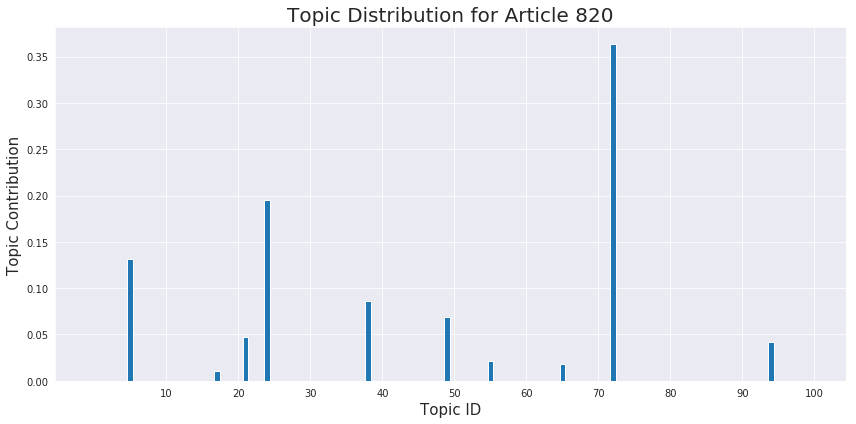

In [34]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [35]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

72 [('dr', 0.11095849), ('volunt', 0.056545205), ('david', 0.050703), ('duke', 0.035031367), ('show', 0.018441092), ('weekli', 0.01781056), ('margaret', 0.017133754), ('flint', 0.016683547), ('wayn', 0.016157793), ('specialist', 0.015061538)] 

24 [('facebook', 0.033841345), ('twitter', 0.031066045), ('media', 0.025781369), ('social', 0.023154646), ('share', 0.02257555), ('news', 0.019259244), ('post', 0.018568309), ('stori', 0.0152641265), ('googl', 0.012325687), ('like', 0.011787222)] 

5 [('go', 0.025943696), ('peopl', 0.02504893), ('dont', 0.019646551), ('get', 0.018800696), ('know', 0.016193187), ('us', 0.014954447), ('want', 0.014511104), ('think', 0.013373876), ('thing', 0.013153101), ('like', 0.013118249)] 

38 [('year', 0.03375223), ('screw', 0.024145966), ('unemploy', 0.021895656), ('dear', 0.021660518), ('expir', 0.021024054), ('princ', 0.020784201), ('softwar', 0.019410035), ('recoveri', 0.018972894), ('last', 0.017954249), ('month', 0.016662078)] 

49 [('post', 0.06680561)

In [0]:
################################# Testing on unseen data ##########################################

In [37]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

3


In [0]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [39]:
print(test_df.iloc[random_article_index,3])

Zach Cartwright | November 6, 2016 
A prominent Native American association is making a powerful statement about offensive sports team logos using indigenous people as mascots. 
The National Congress of American Indians (NCAI), which is behind the effort to change the names and logos of the Washington Redskins football team and the Cleveland Indians baseball team, is circulating a purposefully offensive image using other ethnicities as mascots to promote dialogue about the inappropriateness of having an ethnic stereotype as the face of a team. 
In a poster made by the NCAI, several imaginary sports teams — the New York Jews, the San Francisco Chinamen, and the actual Cleveland Indians are all seen side-by-side. The “New York Jews” mascot is a hook-nosed, bespectacled grinning face, the “San Francisco Chinamen” logo is a buck-toothed Chinese stereotype in a traditional sedge hat, and the Cleveland Indians logo is depicted next to the other two offensive images. 
The evolution of offensi

In [0]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

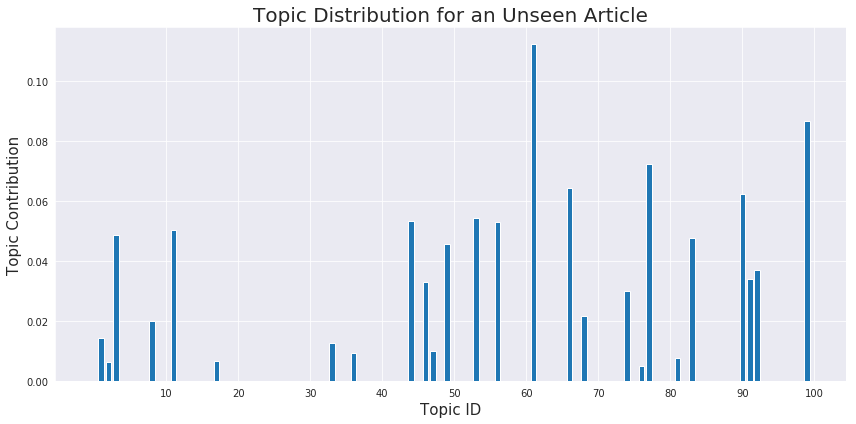

In [41]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [42]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

61 [('trump', 0.15140675), ('donald', 0.03703002), ('elect', 0.014960019), ('support', 0.01446395), ('presid', 0.01307782), ('said', 0.011532393), ('say', 0.011082191), ('american', 0.010372412), ('america', 0.010252569), ('republican', 0.008772827)] 

99 [('one', 0.012151889), ('like', 0.009904013), ('time', 0.008077743), ('would', 0.0070645353), ('get', 0.006935431), ('even', 0.0068867407), ('say', 0.005841959), ('year', 0.0058280285), ('said', 0.005793238), ('peopl', 0.0057855635)] 

77 [('pipelin', 0.035776865), ('dakota', 0.026826683), ('protest', 0.02658307), ('stand', 0.025995709), ('water', 0.024637558), ('rock', 0.02072494), ('north', 0.015412133), ('access', 0.015362067), ('protector', 0.013927995), ('nativ', 0.013716945)] 

66 [('veteran', 0.027463745), ('senat', 0.026586903), ('nation', 0.017074319), ('member', 0.015211934), ('hous', 0.011668696), ('committe', 0.011553562), ('servic', 0.0106925955), ('secretari', 0.010580314), ('serv', 0.010393339), ('presid', 0.009422554)]

In [0]:
#################### Jensen-Shannon Distance ###############

In [44]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(10843, 100)

In [0]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [0]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [0]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [48]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['title']

1332                 Ann Jones: Donald Trump's Open Carry
1497                            Is Nic Cage hair a alien?
1934    Standing Rock Water-Protectors Waterboarded Wh...
4419    Don’t Root, Root, Root for the Racist, Red-Fac...
4489            Debate over the Cleveland Indians’ Mascot
4568    Donald Trump Accused of Failure at not being P...
7088    Is Alex Jones Covering for Trump’s Jewish Mob ...
8361    Comment on HALLOWEEN IN THE CASTRO RETURNS IN ...
8675    Rachel Maddow Shines the Light on Trump’s Whit...
9039    American Express disowns Pink Floyd singer Rog...
Name: title, dtype: object